#B-Number : B01101280
Name: Ankita Patra

# CS 436 / 536: Introduction to Machine Learning
# Spring 2025

## Similarity Based Methods

##### This file relies upon several functions implemented previously in the notebook on Linear Models and Regularization and Validation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
'''
Dependencies
'''
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import permutations, combinations_with_replacement
import copy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [3]:
'''
Init

This is a HACK!
'''

execute = True
execute

True

## Read MNIST Digits Dataset

In [4]:
'''
Reading the MNIST/USPS Handwritten Digits Dataset
'''


def readData(fname='ZipDigits.train'):
    '''
    Input:
        fname: name of file containing N examples, each with d attributes
    Output:
        X: N x d+1 numpy array
        y: N x 1 numpy array
    '''
    with open(fname) as f:
        X = []
        y = []
        rlines = f.readlines()
        for line in rlines:
            row = line.rstrip().split(' ')
            yval = int(float(row[0]))
            y.append(yval)
            xvals = [float(pixel) for pixel in row[1:]]
            X.append(xvals)
        X = np.array(X)
        y = np.array(y)
        y = y.reshape((y.shape[0], 1))
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [5]:
'''
Read training and test datasets
'''
if execute:
    Xdigitstrain, ydigitstrain = readData('/content/drive/My Drive/Colab Notebooks/MLAssignment/ZipDigits.train')

    Ndigitstrain, pixels = Xdigitstrain.shape

    assert(Ndigitstrain == ydigitstrain.shape[0])

    print(f'Xdigitstrain shape {Xdigitstrain.shape}, ydigitstrain shape {ydigitstrain.shape}')

X shape: (7291, 256)
y shape: (7291, 1)
Xdigitstrain shape (7291, 256), ydigitstrain shape (7291, 1)


In [6]:
if execute:
    Xdigitstest, ydigitstest = readData('/content/drive/My Drive/Colab Notebooks/MLAssignment/ZipDigits.test')

    Ndigitstest, pixels = Xdigitstest.shape

    assert(Ndigitstest == ydigitstest.shape[0])

    print(f'Xdigitstest shape {Xdigitstest.shape}, ydigitstest shape {ydigitstest.shape}')

X shape: (2007, 256)
y shape: (2007, 1)
Xdigitstest shape (2007, 256), ydigitstest shape (2007, 1)


### Compute 'Augmented' Feature Matrix

In [7]:
'''
Computing Features
'''


def computeIntensity(X):
    '''
    Compute the average intensity feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        intensities: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     average pixel intesity of the corresponding image
                     See LFD Example 3.1
    '''
    print('computing intensity feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    intensities = np.matmul(X, np.ones((d, 1)))/d
    print(f'Output shape {intensities.shape}')
    return intensities


def computeSymmetry(X):
    '''
    Compute the symmetry feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        symmetries: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     "horizontal" symmetry of the 16 x 16 image about the vertical axis
                     See LFD Example 3.1
    '''
    print('computing symmetry feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    Ximgs = [X[n, :].reshape((16, 16)) for n in range(N)]
    Ximgs_flipped = [np.flip(Ximgs[n], axis=1) for n in range(N)]
    symmetries = [np.sum(np.abs((Ximgs[n] - Ximgs_flipped[n])
                                ).reshape(256, ))/d for n in range(N)]
    symmetries = -np.array(symmetries)
    symmetries = symmetries.reshape(N, 1)
    print(f'Output shape {symmetries.shape}')
    return symmetries

In [8]:
'''
Computing the augmented feature matrix
'''


def computeAugmentedXWithFeatures(X):
    '''
    Compute the augmented feature matrix
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        Xaug: a 2 dimensional N x 3 numpy array
              the augmented feature matrix
              the i-th row corresponds to the i-th row of X (and image represented by it)
              the 0-th column is the column of 1s
              the 1-st column is the column of average intensities
              the 2-nd column is the column of horizontal symmetries
    '''
    N, d = X.shape
    intensity = computeIntensity(X)
    symmetry = computeSymmetry(X)
    dummy = np.ones((N, 1))
    Xaug = np.concatenate((dummy, intensity, symmetry), axis=1)
    # print(Xaug)
    print(f'Shape of augmented feature matrix: {Xaug.shape}')
    return Xaug

In [10]:
if execute:
    print('Computing augmented training feature matrix')

    Xaugtrain = computeAugmentedXWithFeatures(Xdigitstrain)

    Naugtrain, d = Xaugtrain.shape

    print(f'Xaugtrain shape {Xaugtrain.shape}')

Computing augmented training feature matrix
computing intensity feature
Input shape 7291, 256
Output shape (7291, 1)
computing symmetry feature
Input shape 7291, 256
Output shape (7291, 1)
Shape of augmented feature matrix: (7291, 3)
Xaugtrain shape (7291, 3)


In [11]:
if execute:
    print('Computing augmented test feature matrix')

    Xaugtest = computeAugmentedXWithFeatures(Xdigitstest)

    Naugtest, d = Xaugtest.shape

    print(f'Xaugtest shape {Xaugtest.shape}')

Computing augmented test feature matrix
computing intensity feature
Input shape 2007, 256
Output shape (2007, 1)
computing symmetry feature
Input shape 2007, 256
Output shape (2007, 1)
Shape of augmented feature matrix: (2007, 3)
Xaugtest shape (2007, 3)


### Combine Data

In [12]:
if execute:
    Xaug = np.concatenate((Xaugtrain, Xaugtest), axis=0)
    Naug, d = Xaug.shape
    ycombined = np.concatenate((ydigitstrain, ydigitstest), axis=0)

    assert(Xaug.shape[0] == Ndigitstrain + Ndigitstest)
    assert(ycombined.shape[0] == Ndigitstrain + Ndigitstest)

    print(f'Xaug shape {Xaug.shape}, ycombined shape {ycombined.shape}')

Xaug shape (9298, 3), ycombined shape (9298, 1)


### Normalize Features

In [13]:


def normalize(X, a=-1, b=1):
    N, d = X.shape
    Xnorm = np.ones((N, d))
    for col in range(1, d):  # assuming column 0 is already set (e.g., bias term)
        Xcol = X[:, col]
        Xmin = np.min(Xcol)
        Xmax = np.max(Xcol)
        # Avoid division by zero in case all values in the column are the same.
        if Xmax != Xmin:
            Xcolnorm = a + (Xcol - Xmin) * (b - a) / (Xmax - Xmin)
        else:
            Xcolnorm = np.full_like(Xcol, a)
        Xnorm[:, col] = Xcolnorm
    return Xnorm


In [14]:
Xnorm = normalize(Xaug)
N, d = Xnorm.shape

assert(Xnorm.shape == Xaug.shape)
assert(np.all( Xnorm[:, 0] == np.ones((N, 1)) ))

In [15]:
if execute:
    Xnorm = normalize(Xaug)
    N, d = Xnorm.shape
    print(Xnorm.shape)

    assert(Xnorm.shape == Xaug.shape)
    assert(np.all( Xnorm[:, 0] == np.ones((N, 1)) ))

(9298, 3)


### Setup Labels for the 1s vs Non 1s Classification Task

In [16]:
if execute:
    for n in range(N):
        if ycombined[n, 0] == 1:
            ycombined[n, 0] = 1
        else:
            ycombined[n, 0] = -1

In [63]:
import numpy as np

def splitDataSelectKRandomly(X, y, K):
    '''
    Partitions the input dataset with N data points given by X and y into two parts,
    one with K of the data points selected uniformly at random, and
    the other with the remaining N-K data points
    Input:
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set.
           X[n, 0] = 1 (e.g., bias term) and X[n, 1], ..., X[n, d-1] are feature values.
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example.
        K: an integer; number of data points to select.
    Output:
        Xselected: a 2 dimensional K x d numpy array, containing K data points selected from X uniformly at random.
        yselected: a 2 dimensional K x 1 numpy array, containing the labels from y corresponding to Xselected.
        Xremaining: a 2 dimensional (N-K) x d numpy array.
        yremaining: a 2 dimensional (N-K) x 1 numpy array.
    '''
    N, d = X.shape
    # Generate an array of indices for all data points
    indices = np.arange(N)
    # Randomly select K unique indices
    selected_indices = np.random.choice(indices, size=K, replace=False)
    # The remaining indices are those not selected
    remaining_indices = np.setdiff1d(indices, selected_indices)

    # Partition the dataset using the selected indices
    Xselected = X[selected_indices, :]
    yselected = y[selected_indices, :]
    Xremaining = X[remaining_indices, :]
    yremaining = y[remaining_indices, :]

    return Xselected, yselected, Xremaining, yremaining


## Train-Test Split

### Randomly select $K$ data points from the input data

In [75]:
if execute:
    X, y, Xtest, ytest = splitDataSelectKRandomly(Xnorm, ycombined, 300)

    print(f'Xnorm shape {Xnorm.shape} ycombined shape {ycombined.shape}\n\
    X shape {X.shape} y shape {y.shape}\n\
    Xtest shape {Xtest.shape}, ytest shape {ytest.shape}')

Xnorm shape (9298, 3) ycombined shape (9298, 1)
    X shape (300, 3) y shape (300, 1)
    Xtest shape (8998, 3), ytest shape (8998, 1)


### Visualize the Data

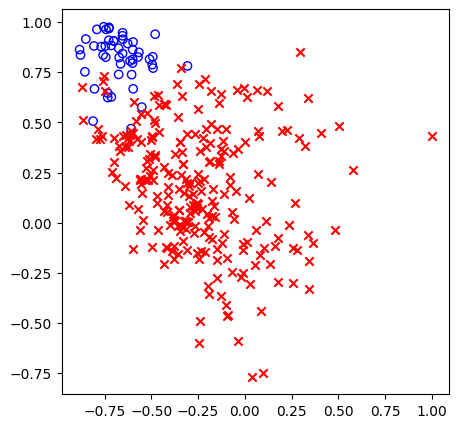

In [76]:
if execute:
    fig, axs = plt.subplots(figsize=(5, 5))
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')

## Computing Distances

In [89]:
def vec2vecDistance(x, xprime, ord=2):
    '''
    Compute distance between two vectors
    Input:
        x: a d-dimensional numpy vector
        xprime: a d-dimensional vector
        ord: order of the norm used to compute distance
    Output:
        distance: a real number
    '''
    return np.linalg.norm(x - xprime, ord=ord)


In [90]:
def vec2matDistances(x, X, ord=2):
    '''
    Compute distance between a vector and each row in a matrix
    Input:
        x: a d-dimensional numpy vector
        X: a 2D N x d numpy array
        ord: order of the norm used to compute distance
    Output:
        distances: a 2D N x 1 numpy array of distances from x to data points in X
    '''
    distances = np.linalg.norm(X - x, ord=ord, axis=1)
    return distances.reshape(-1, 1)


## Computing Error

In [91]:
def classificationError(y, yhat):
    '''
    The (mis)classification error
    Input:
        y: a 2D N x 1 numpy array
        yhat: a 2D N x 1 numpy array
    Output:
        error: a real number, fraction of examples at which the value in y is not equal to the value in yhat
    '''
    N, d = y.shape
    error = np.sum(y != yhat) / N
    return error


In [92]:
def regressionError(y, yhat):
    '''
    The regression error
    Input:
        y: a 2D N x 1 numpy array
        yhat: a 2D N x 1 numpy array
    Output:
        error: mean squared error between y and yhat
    '''
    N, d = y.shape
    error = (1 / N) * (np.matmul(yhat.T, yhat) - 2 * np.matmul(yhat.T, y) + np.matmul(y.T, y))[0, 0]
    return error


## The $k$ Nearest Neighbors Rule

In [93]:
def kNN(X, y, xtest, k=3):
    '''
    The k Nearest Neighbors Algorithm
    Input:
        X: a 2D N x d numpy array
        y: a 2D N x 1 numpy array
        xtest: a d dimensional vector
        k: positive integer
    Output:
        ytest: prediction on xtest using the k Nearest Neighbors Algorithms and dataset X, y
    '''
    distances = vec2matDistances(xtest, X)

    # TODO-5: Get indices of k nearest neighbors
    kNeighbors = np.argpartition(distances[:, 0], k)[:k]

    # TODO-6: Average the y values of the k nearest neighbors
    ytest = np.mean(y[kNeighbors])

    return ytest


### Making Predictions

In [94]:
def predictClasskNN(X, y, Xtest, k=3):
    '''
    Predict class using the k Nearest Neighbors Algorithm
    Input:
        X: a 2 dimensional N x d numpy array
        y: a 2 dimensional N x 1 numpy array
        Xtest: a 2D Ntest x d numpy array
        k: positive integer
    Output:
        ytest: a 2D Ntest x 1 numpy array of predicted classes of examples in Xtest
    '''
    N, d = Xtest.shape
    yhat = np.zeros((N, 1))
    for n in range(N):
        xtest = Xtest[n, :]
        # TODO-7: predict using sign of average of k nearest neighbors' labels
        yhat[n, 0] = np.sign(kNN(X, y, xtest, k))
    return yhat


### Plotting the Decision Boundary of the $k$ Nearest Neighbors Rule

In [95]:
def plotkNNSeparator(X, y, k=3, title=''):
    '''
    Plot the "effective" decision boundary and half spaces
    determined by the k Nearest Neighbors Algorithm
    Input:
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0], ..., X[n, d-1] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        k: positive integer
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(10, 10))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 1, 250)
    pltx2s = np.linspace(-1, 1, 250)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    pltyhat = predictClasskNN(X, y, pltX, k=k)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')
    '''
    Finishing touches
    '''
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title(title)
    axs.legend()
    plt.show()

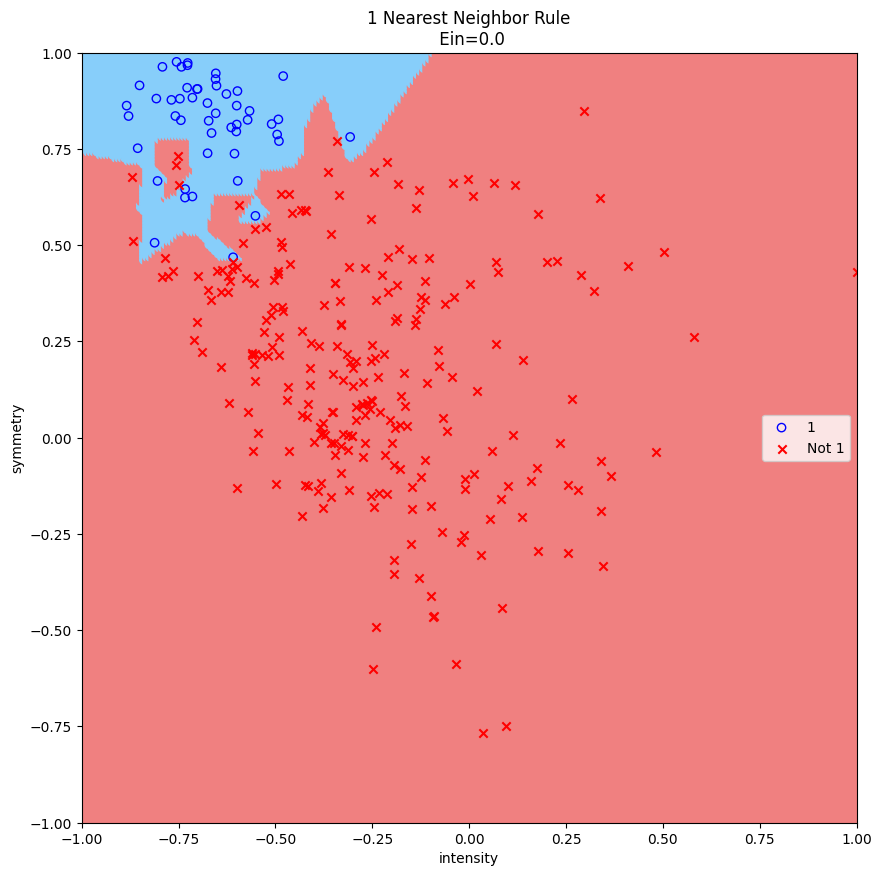

In [96]:
k=1

yhat = predictClasskNN(X, y, X, k=k)
Ein = classificationError(y, yhat)

plotkNNSeparator(X, y, k=k, title=f'{k} Nearest Neighbor Rule\n Ein={Ein}')

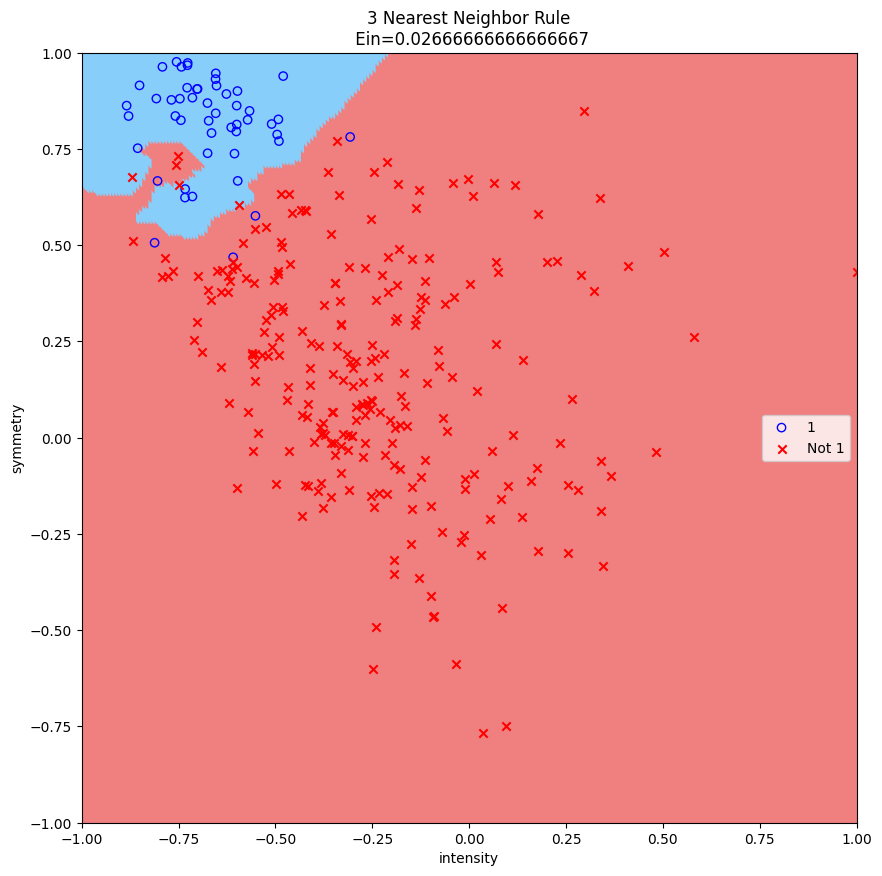

In [98]:
k=3

yhat = predictClasskNN(X, y, X, k=3)
Ein = classificationError(y, yhat)

plotkNNSeparator(X, y, k=k, title=f'{k} Nearest Neighbor Rule\n Ein={Ein}')

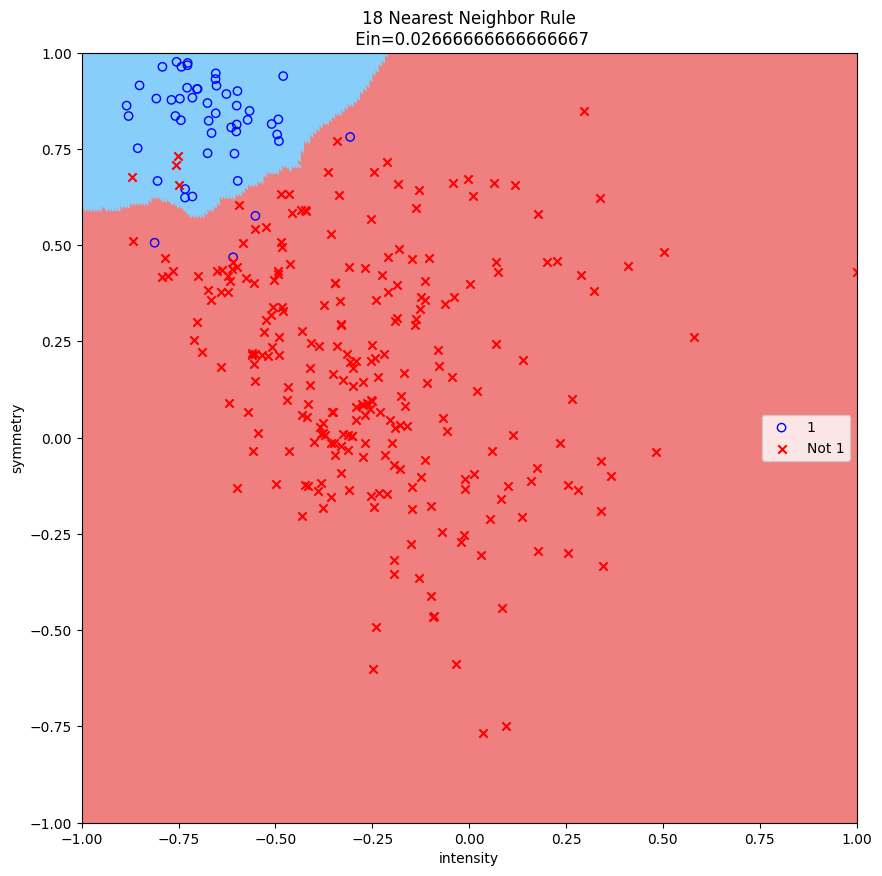

In [99]:
N, d = X.shape
k = np.ceil(np.sqrt(N)).astype(int)

yhat = predictClasskNN(X, y, X, k=k)
Ein = classificationError(y, yhat)

plotkNNSeparator(X, y, k=k, title=f'{k} Nearest Neighbor Rule\n Ein={Ein}')

## $k$ Means Clustering
### Lloyd's Algorithm
#### Greedy Algorithm to Pick Initial Centers

In [100]:
def kSeparatedPointsGreedy(X, k=3):
    '''
    Select k data points from X that are far from each other
    Input:
        X: a 2D N x d numpy array
    Output:
        S: a 2D k x d numpy array
    '''
    N, d = X.shape
    if k == N:
        return X
    S = np.zeros((k, d))
    for j in range(k):
        if j == 0:
            '''
            Add a random point to S
            '''
            idx = np.random.randint(low=0, high=N)
            S[0, :] = X[idx, :]
            continue
        '''
        Add a point from X that is farthest away from its nearest neighbor in S
        '''
        Selected = S[:j-1, :].reshape((j-1, d))
        distancesXtoS = np.zeros((N, 1))
        for n in range(N):
            x = X[n, :]
            distances_x_to_S = vec2matDistances(x, S)
            distancesXtoS[n, 0] = np.min(distances_x_to_S)
        idx = np.argmax(distancesXtoS)
        S[j, :] = X[idx, :]
    return S

#### Compute Cluster Membership Given Cluster Centers

In [101]:
def clusterMembership(centers, X):
    '''
    Given k cluster centers, identify for each data point in X, which cluster it belongs to
    Input:
        centers: a 2D k x d numpy array of k cluster centers in d-dimensional space
        X: a 2D N x d numpy array of N data points in d-dimensional space
    Output:
        membership: a 2D N x 1 numpy array, specifying the cluster to which each data point in X belongs
                    membership[n, 0] is an integer specifying which one of k clusters the n-th data point in X belongs to
    '''
    k, d = centers.shape
    N, dprime = X.shape
    assert(d == dprime)
    membership = np.zeros((N, 1)).astype(int)
    for n in range(N):
        x = X[n, :]
        distances_x_to_centers = vec2matDistances(x, centers)
        membership[n, 0] = np.argmin(distances_x_to_centers)
    return membership

In [102]:
def getClusterMembers(centers, X):
    '''
    Compute cluster membership
    Input:
        centers: a 2D k x d numpy array, k centers
        X: a 2D N x d numpy array, N data points
    Output:
        S: a list of length k;
           for each j=0,...,k-1, S[j] is a 2D numpy array with d columns
           consisting of data points from X closest to center j
        members: a list of length k;
                 for each j=0,...,k-1, members[j] is a list of indices of rows in X closest to the j-th center
    '''
    k, d = centers.shape
    N, dprime = X.shape
    assert(d == dprime)
    membership = clusterMembership(centers, X)
    S = []
    members = []
    for j in range(k):
        idxs = [n for n in range(N) if membership[n, 0] == j]
        Sj = X[idxs, :]
        S.append(Sj)
        members.append(idxs)
    return S, members

#### Compute Cluster Error

##### Given:

$k$ cluster centers $\mu_1,\dots,\mu_k$, and

$N$ data points from a dataset $X$

##### Want:

Compute the cluster error:

$E_{\text{in}}(x_1,\dots,x_N; \mu_1,\dots,\mu_k)=\sum_{n=1}^N\left\| x_n - \mu(x_n) \right\|^2$, where $\mu(x_n)$ is the cluster center closest to $x_n$ among the $k$ cluster centers $\mu_1,\dots,\mu_k$.

Equivalent to:

When $S_1,\dots,S_k$ is a $k$-partition of $X$, where for each $j\in\{1,\dots,k\}$, $S_j$ is the set of data points in $X$ belonging to cluster $j$, i.e., that are closer to $\mu_j$ than any other cluster center.

$E_{\text{in}}(S_1,\dots,S_k; \mu_1,\dots,\mu_k)=\sum_{j=1}^N E_j$, where $E_j=\sum_{n:x_n\in S_j}\left\| x_n - \mu_j \right\|^2$

In [112]:
def clusterError(centers, X):
    '''
    Compute the cluster error
    Input:
        centers: a 2D k x d numpy array, k centers
        X: a 2D N x d numpy array, N data points
    Output:
        E: a real number, the cluster error
    '''
    k, d = centers.shape
    N, dprime = X.shape
    assert(d == dprime)
    membership = clusterMembership(centers, X)
    E = 0
    for n in range(N):
        cluster = membership[n, 0]
        center = centers[cluster, :]
        x = X[n, :]
        # TODO-8: accumulate squared distance from x to its assigned cluster center
        E += np.linalg.norm(x - center) ** 2

    return E


In [113]:
def clusterStats(centers, X):
    '''
    Print some useful stats about a clustering of X defined by centers
    Input:
        centers: a 2D k x d numpy array, k centers
        X: a 2D N x d numpy array, N data points
    Output:
        None
    '''
    k, d = centers.shape
    N, dprime = X.shape
    assert(d == dprime)
    membership = clusterMembership(centers, X)
    E = clusterError(centers, X)
    S, membership = getClusterMembers(centers, X)
    print(f'centers shape {k, d}\ndata shape {N, dprime}\ncluster error {E}\n')
    for j in range(k):
        Nj, dj = S[j].shape
        Ej = clusterError(centers[j, :].reshape((1, d)), S[j])
        print(f'Cluster {j} has {Nj} members with cluster error {Ej}')
    return None

#### Plot Clusters

In [114]:
def plotClusters(centers, X, title=''):
    '''
    Plot clusters and cluster centers
    Input:
        centers: a 2D k x d numpy array, k centers
        X: a 2D N x d numpy array, N data points
        title: a string
    Output:
        None
    '''
    k, d = centers.shape
    N, dprime = X.shape
    assert(d == dprime)
    membership = clusterMembership(centers, X)
    S, members = getClusterMembers(centers, X)
    cmap = plt.get_cmap("tab10")
    fig, axs = plt.subplots(figsize=(10, 10))
    for j in range(k):
        pltx = S[j][:, 1]
        plty = S[j][:, 2]
        axs.scatter(pltx, plty, marker='x', color=cmap(float(j)/k), alpha=0.5, label=f'cluster {j}')
        pltxcenter = centers[j, 1]
        pltycenter = centers[j, 2]
        axs.scatter(pltxcenter, pltycenter, s=100, marker='o', color=cmap(float(j)/k), label=f'cluster {j} center')
    axs.legend()
    axs.set_title(title)
    plt.tight_layout()
    plt.show()

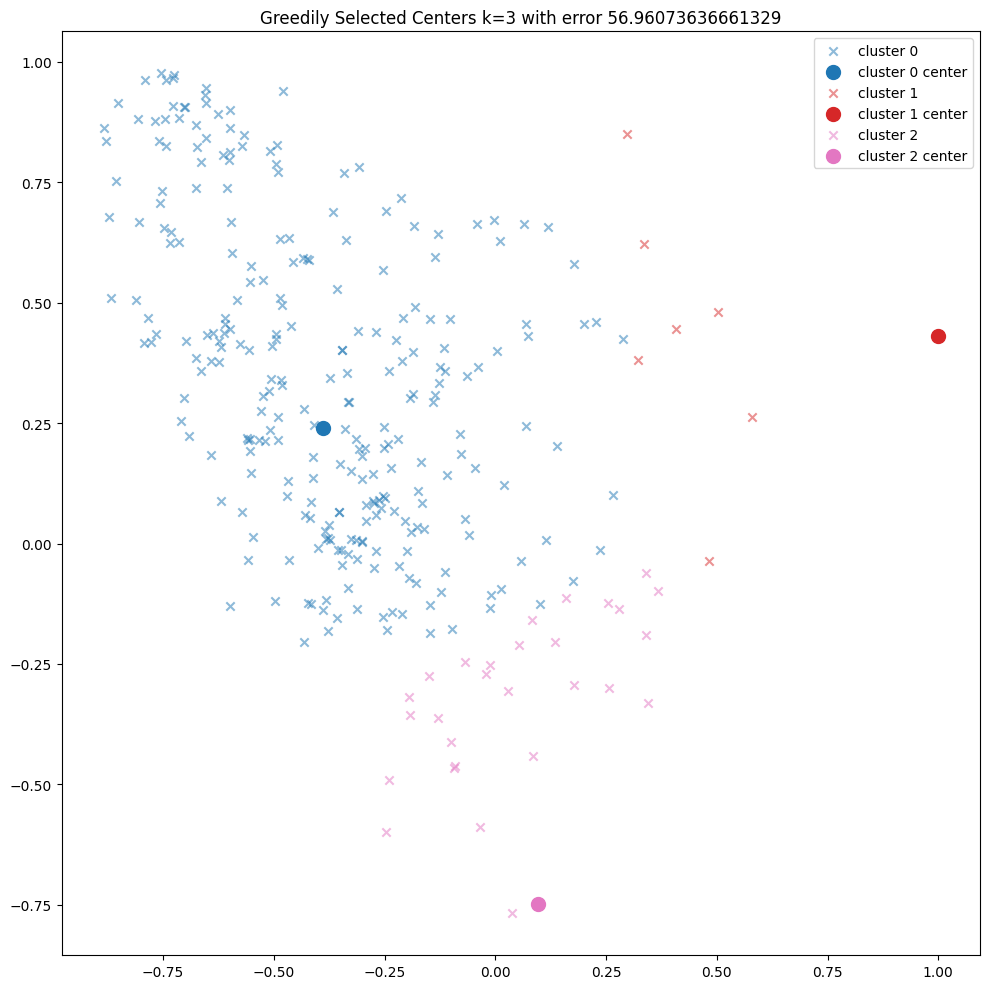

In [116]:
k = 3
centers = kSeparatedPointsGreedy(X, k=k)
error = clusterError(centers, X)
plotClusters(centers, X, title=f'Greedily Selected Centers k={k} with error {error}')

#### Lloyd's Algorithm

1. Start with cluster centers using the greedy algorithm
2. Compute cluster membership
3. Update cluster centers
4. Compute cluster error and repeat 2 and 3 until cluster error stops decreasing

In [122]:
def clusterLloyds(X, k=3, tol=0.000001):
    '''
    Lloyd's algorithm for clustering
    Input:
        X: a 2D N x d numpy array
        k: an integer, the desired number of clusters
    Output:
        centers: a 2D k x d numpy array of k cluster centers in d-dimensional space
    '''
    # Initialize cluster centers
    centers = kSeparatedPointsGreedy(X, k=k)
    N, d = X.shape
    error = clusterError(centers, X)
    errors = [error]

    while True:
        # Construct clusters S[j] for each j = 1, ..., k
        S, members = getClusterMembers(centers, X)

        # Update cluster centers
        for j in range(k):
            if len(S[j]) > 0:
                centers[j, :] = np.mean(S[j], axis=0)  # TODO-9
            # Optional: handle empty clusters if needed

        # Compute cluster error
        E = clusterError(centers, X)  # TODO-10
        errors.append(E)

        # Convergence check
        if abs(errors[-2] - errors[-1]) < tol:
            break

    print(f'completed {k} clusters with cluster error {errors[-1]}')
    return centers


completed 3 clusters with cluster error 25.055338432070513


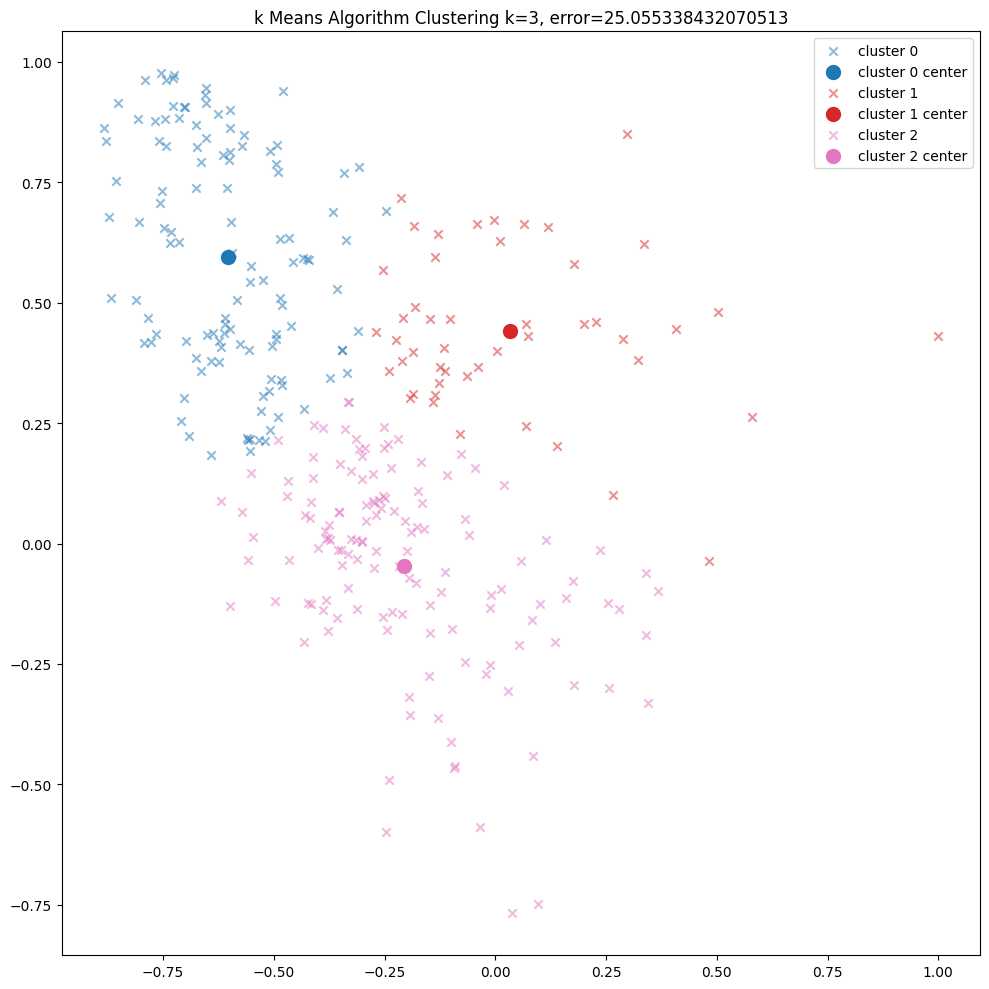

In [123]:
k = 3
centers = clusterLloyds(X, k=k)
error = clusterError(centers, X)
plotClusters(centers, X, title=f'k Means Algorithm Clustering k={k}, error={error}')

## Radial Basis Functions
### The Gaussian Kernel

$\phi_{\text{Gauss}}(s)=e^{-\frac{1}{2}s^2}$

In [124]:
def GaussianKernel(s):
    '''
    The Gaussian kernel
    Input:
        s: a real number or numpy vector
    Output:
        a real number or numpy vector (depending on the input) of the Gaussian kernel applied to the input
    '''
    return np.exp(-s**2)


### Nonparametric RBF

Given a dataset $X$, $y$, and a test data point $x$

$h(x)=\sum_{n=1}^N w_n(x)\phi\big(\frac{\left\| x-x_n \right\|}{r}\big)$

where $x_n$ is the $n$-th data point in $X$,

and $w_n(x)=\frac{y_n}{\sum_{m=1}^N\phi\big(\frac{\left\|x-x_m\right\|}{r}\big)}$

In [129]:
def nonparametricRBF(X, y, xtest, r=0.1):
    '''
    The nonparametric RBF function
    Input:
        centers: a 2D k x d numpy array, k centers
        X: a 2D N x d numpy array, N data points
        xtest: a d-dimensional numpy vector
        r: a real number
    Output:
        yhat: a real number, the prediction of the nonparametric RBF on data point xtest
    '''
    N, d = X.shape
    distances = vec2matDistances(xtest, X)
    distances = distances / r
    norm = np.sum(distances)
    ztest = GaussianKernel(distances)
    w = y / norm
    yhat = np.matmul(w.T, ztest)
    return yhat

In [130]:
def predictClassNonparametricRBF(X, y, Xtest, r=0.1):
    '''
    Input:
        X: a 2D N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0], ..., X[n, d-1] have values of features
        y: a 2D N x 1 numpy array
           y[n, 0] is the label associated with the n-th example
        Xtest: a 2D Ntest x d numpy array
        r: a positive real number
    Output:
        yhat: a 2D N x 1 numpy array
              yhat[n, 0] is the label associated with the n-th example in Xtest
    '''
    N, d = Xtest.shape
    yhat = np.zeros((N, 1))
    for n in range(N):
        xtest = Xtest[n, :]
        yhat[n, 0] = np.sign(nonparametricRBF(X, y, xtest, r=r))
    return yhat

#### Making Predictions

In [131]:
def plotNonparametricRBFSeparator(X, y, r=0.1, title=''):
    '''
    Plot the "effective" decision boundary and half spaces determined by the nonparametric RBF
    Input:
        X: a 2D N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0], ..., X[n, d-1] have values of features
        y: a 2D N x 1 numpy array
           y[n, 0] is the label associated with the n-th example
        r: positive real number
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(10, 10))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 1, 250)
    pltx2s = np.linspace(-1, 1, 250)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    pltyhat = predictClassNonparametricRBF(X, y, pltX, r=r)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')
    '''
    Finishing touches
    '''
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title(title)
    axs.legend()
    plt.show()

<ipython-input-130-3380d1271653>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat[n, 0] = np.sign(nonparametricRBF(X, y, xtest, r=r))


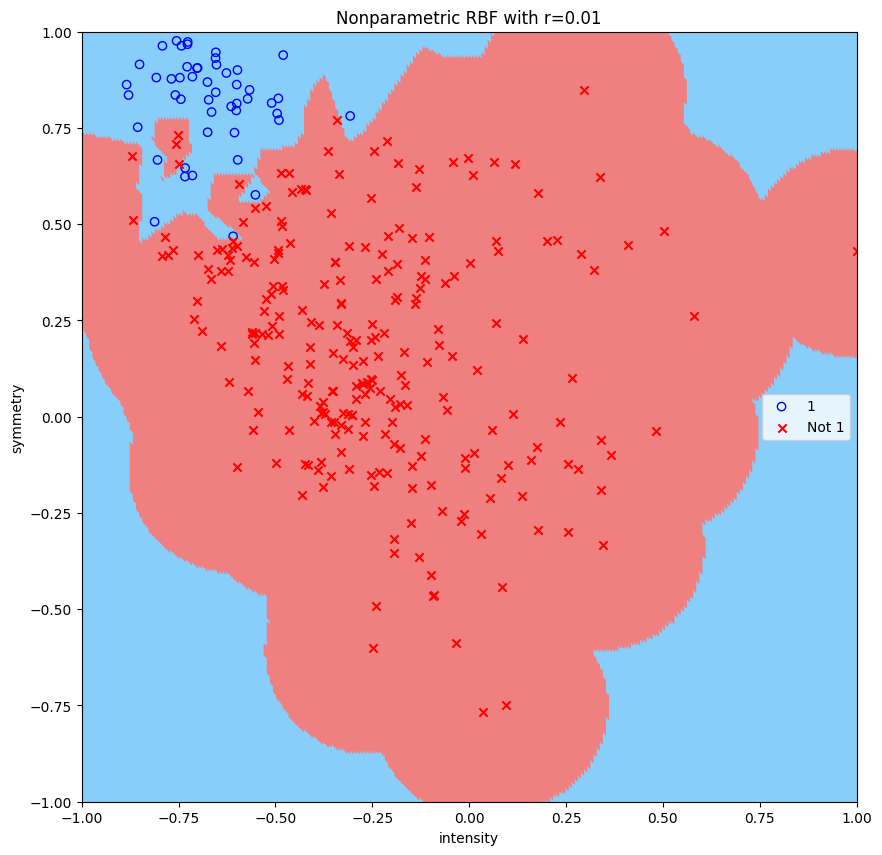

In [133]:
r = 0.01
title = f'Nonparametric RBF with r={r}'
plotNonparametricRBFSeparator(X, y, r=r, title=title)

<ipython-input-130-3380d1271653>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat[n, 0] = np.sign(nonparametricRBF(X, y, xtest, r=r))


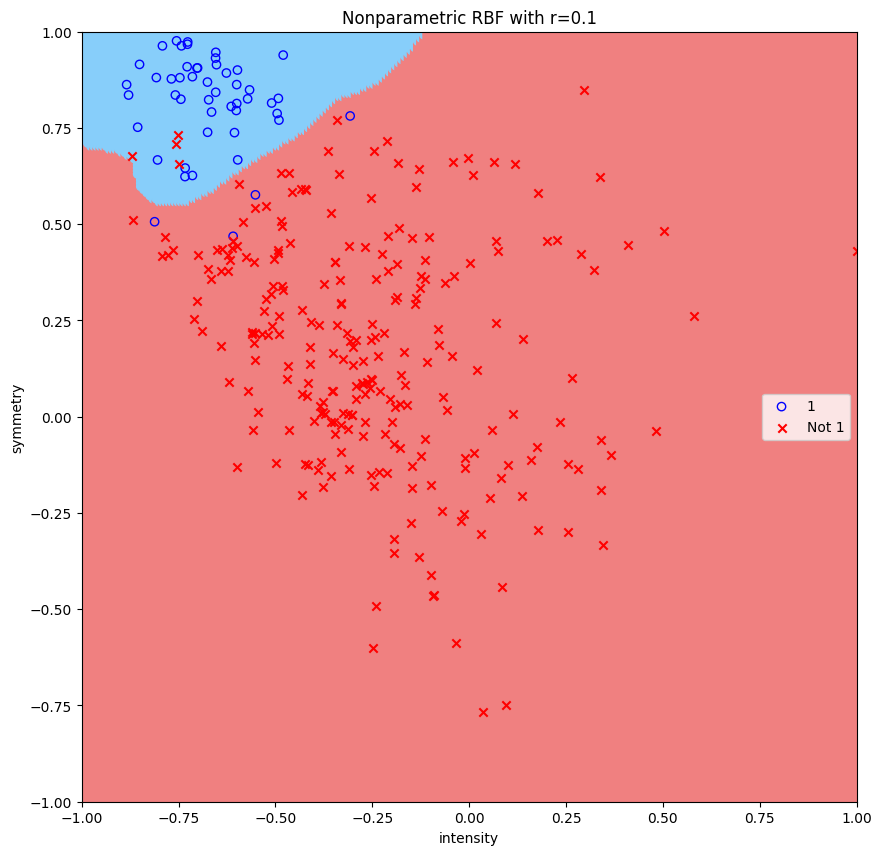

In [134]:
r = 0.1
title = f'Nonparametric RBF with r={r}'
plotNonparametricRBFSeparator(X, y, r=r, title=title)

### Parametric RBF

Given a dataset $X$, $y$ with $N$ data points, and $k<N$ centers $\mu_1,\dots,\mu_k$,

$h(x)=w_0 + \sum_{j=1}^k w_j\phi\big(\frac{\left\| x-\mu_j \right\|}{r}\big)$

$h(x)=w^T \Phi(x)$


Together, $w$ and $\mu_1,\dots,\mu_k$ define a parametric RBF hypothesis



#### Compute Similarity Features


In [135]:
def similarity(x, centers, r=0.1):
    '''
    Similarity features
    Input:
        x: a d-dimensional numpy vector
        centers: a 2D k x d numpy array
        r: a real number
    Output:
        similarities: a 2D k x 1 numpy array, similarities[j, 0] is the similarity of x to the j-th center
    '''
    k, d = centers.shape
    distances = vec2matDistances(x, centers)  # shape: (k, 1)
    scaled_distances = distances / r
    similarities = GaussianKernel(scaled_distances)
    return similarities


#### Compute (Augmented) Similarity Feature Matrix

In [136]:
def computeAugmentedZWithSimilarities(X, centers, r=0.1):
    '''
    Similarity features
    Input:
        X: a 2D N x d numpy array
        centers: a 2D k x d numpy array
        r: a real number
    Output:
        Z: a 2D N x (k+1) numpy array,
           Z[:, 0] is a columns of 1s
           Z[n, j] is the similarity of the n-th data point in X with the j-th center
    '''
    N, d = X.shape
    k, dprime = centers.shape
    Z = np.zeros((N, k))
    for n in range(N):
        x = X[n, :]
        similarities = similarity(x, centers, r=r)
        Z[n, :] = similarities.T
    if k < N:
        dummy = np.ones((N, 1))
        Z = np.concatenate((dummy, Z), axis=1)
    Ntilde, dtilde = Z.shape
    assert(Ntilde == N)
    if k < N:
        assert(dtilde == k + 1)
    else:
        assert(dtilde == N)
    return Z

#### Fit the Data

Optimal weights $w^*=Z^\dagger y$

where $Z^\dagger$ is the pseudo-inverse of $Z$

In [138]:
def fitParametricRBFRegression(X, y, r=0.1, k=3):
    '''
    Fit the Data to Compute the Optimal Weights for the Parametric RBF
    Input:
        X: a 2D N x d numpy array
        y: a 2D N x 1 numpy array
        r: a positive real number
        k: a positive integer, number of centers to use for the parametric RBF
    Output:
        w: a 2D (k+1) x 1 numpy array of optimal weights for regression
        centers: a 2D k x d numpy array of cluster centers for the parametric RBF
    '''
    N, d = X.shape

    # TODO-13: Compute k centers using Lloyd's algorithm
    centers = clusterLloyds(X, k=k)

    # Compute similarity features (augmented with bias column)
    Z = computeAugmentedZWithSimilarities(X, centers, r=r)

    # TODO-14: Compute optimal weights using pseudoinverse
    w = np.linalg.pinv(Z) @ y

    return w, centers


#### Making Predictions

$\hat{y}=Zw$

In [139]:
def predictClassParametricRBF(w, centers, Xtest, r=0.1):
    '''
    Input:
        w: a 2D (k+1) x 1 numpy array
        centers: a 2D k x d numpy array
        Xtest: a 2D Ntest x d numpy array
        r: a positive real number
    Output:
        yhat: a 2D N x 1 numpy array
              yhat[n, 0] is the label associated with the n-th example in Xtest
    '''
    Ztest = computeAugmentedZWithSimilarities(Xtest, centers, r=r)

    # TODO-15: Compute predicted labels
    yhat = np.sign(Ztest @ w)

    return yhat


#### Plotting the Decision Boundary of the Parametric RBF

In [140]:
def plotParametricRBFSeparator(w, centers, X, y, r=0.1, title=''):
    '''
    Plot the "effective" decision boundary and half spaces determined by a parametric RBF hypothesis
    Input:
        w: a 2D (k+1) x 1 numpy array of weights
        centers: a 2D k x d numpy array
                 The j-th row centers[j, :] is the location of the j-th center
        X: a 2D N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0], ..., X[n, d-1] have values of features
        y: a 2D N x 1 numpy array
           y[n, 0] is the label associated with the n-th example
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(10, 10))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 1, 250)
    pltx2s = np.linspace(-1, 1, 250)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    pltyhat = predictClassParametricRBF(w, centers, pltX, r=r)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')
    '''
    Plot centers
    '''
    k, d = centers.shape
    print(f'centers shape {k, d}')
    pltcentersx1 = centers[:, 1]
    pltcentersx2 = centers[:, 2]
    axs.scatter(pltcentersx1, pltcentersx2, s=100, marker='o', color='black', label=f'centers')
    '''
    Finishing touches
    '''
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title(title)
    axs.legend()
    plt.tight_layout()
    plt.show()

completed 50 clusters with cluster error 1.0300358276483528
centers shape (50, 3)


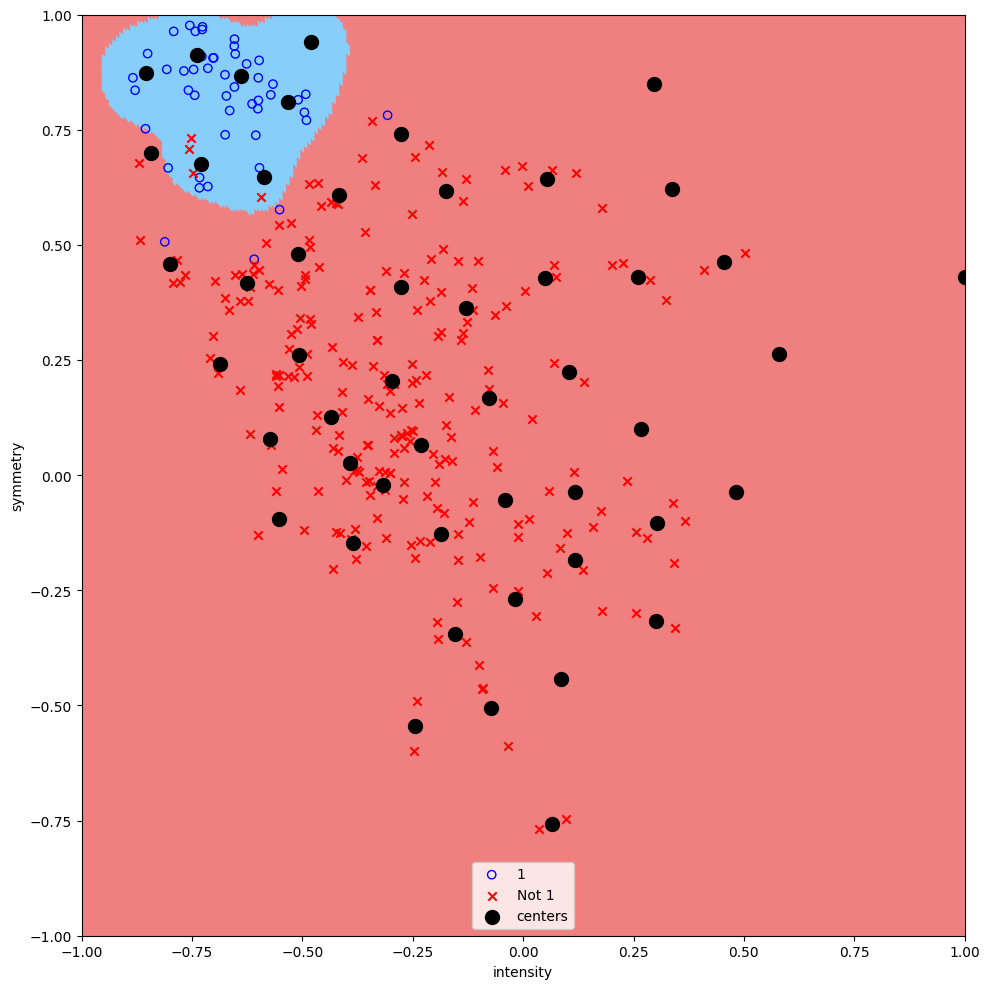

In [141]:
k = 50
r = 0.1
title=f'Parametric RBF, k={k}, r={r}'
w, centers = fitParametricRBFRegression(X, y, r=r, k=k)
plotParametricRBFSeparator(w, centers, X, y, r=r)